In [292]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np

from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.drivers.spads.spad import SPADDataType

from ml.model import DeepLocation8
from ml.dataloader import create_dataloaders

In [417]:
root_dir = Path("../../../")
pkl_path = Path("logs/2025-06-10/12-58-53/data.pkl")
pkl_path = Path("logs/2025-06-10/13-55-27/data.pkl")
pkl_path = Path("logs/2025-06-10/14-49-47/data.pkl")
pkl_path = Path("logs/2025-06-10/17-44-03/data.pkl")
pkl_path = Path("logs/2025-06-10/19-11-25/data.pkl")
pkl_path = root_dir / pkl_path
assert pkl_path.exists(), f"File {pkl_path} does not exist."

pkl_reader = PklReader(pkl_path)

config = pkl_reader.load(0)
assert "config" in config
config = config["config"]

backgrounds = []
for frame in pkl_reader:
    if frame.get("background", False):
        backgrounds.append(frame[SPADDataType.HISTOGRAM])

captures = []
for frame in pkl_reader:
    if "pos" in frame:
        captures.append(frame)

# mean_background_capture = np.mean(backgrounds, axis=0) if backgrounds else None
# if mean_background_capture is not None:
#     for capture in captures:
#         capture[SPADDataType.HISTOGRAM] -= mean_background_capture

# mean_capture = np.mean([c[SPADDataType.HISTOGRAM] for c in captures], axis=0)
# for capture in captures:
#     capture[SPADDataType.HISTOGRAM] -= mean_capture

# if backgrounds:
#     capture_copies = basic_captures.copy()
#     avg_background = np.mean(backgrounds, axis=0)
#     for capture in capture_copies:
#         capture[SPADDataType.HISTOGRAM] -= avg_background
#         captures.append(capture)

# mean_capture = np.mean([c[SPADDataType.HISTOGRAM] for c in captures], axis=0)
# capture_copies = basic_captures.copy()
# for capture in capture_copies:
#     capture[SPADDataType.HISTOGRAM] -= mean_capture
#     captures.append(capture)

print(f"Loaded {len(backgrounds)} backgrounds and {len(captures)} captures.")

Loaded 0 backgrounds and 400 captures.


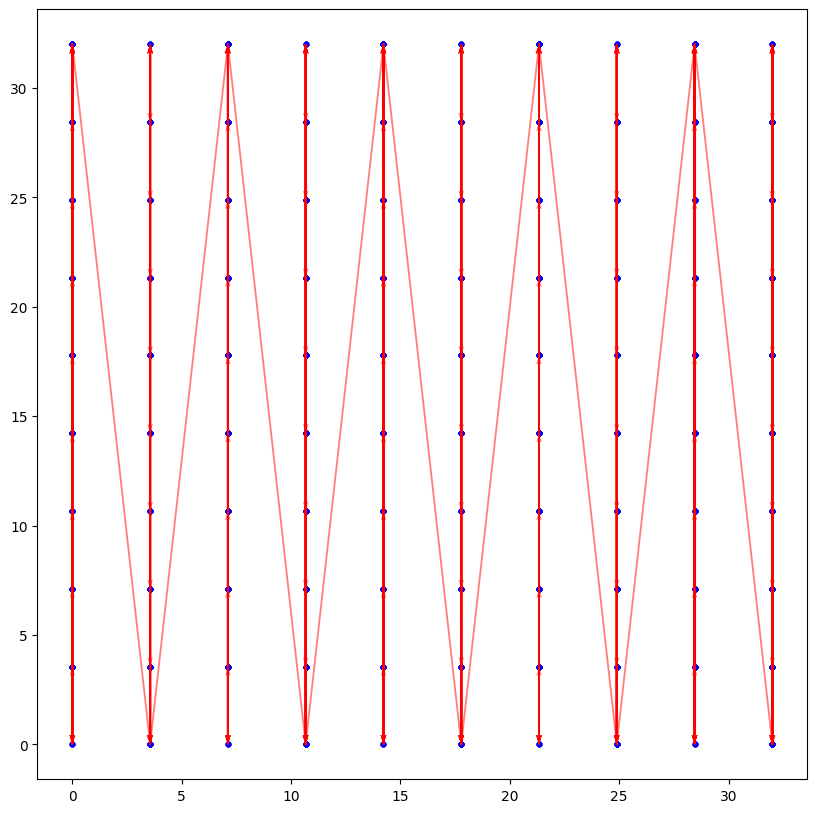

In [226]:
import numpy as np

positions = np.array([[frame["pos"]["x"], frame["pos"]["y"]] for frame in captures])
x, y = positions[:, 0], positions[:, 1]
dx, dy = np.diff(x), np.diff(y)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c="blue", s=10, alpha=0.5)
plt.quiver(x[:-1], y[:-1], dx, dy, angles='xy', scale_units='xy', scale=1, color='red', alpha=0.5)
plt.gca().set_aspect("equal", "box")

In [418]:
from torch import optim
from tqdm.auto import tqdm

# ---- dataloader ----
cfg_h, cfg_w, cfg_bins = config["height"], config["width"], config["num_bins"]

train_loader, val_loader = create_dataloaders(
    captures, h=cfg_h, w=cfg_w, bins=cfg_bins, window=1, split=0.8
)

# ---- model ----
model = DeepLocation8(height=cfg_h, width=cfg_w, num_bins=cfg_bins).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- training loop ----
epochs = 200
train_losses, val_losses = [], []

device = next(model.parameters()).device
for epoch in tqdm(range(epochs), desc="Epochs"):
    # train
    model.train()
    t_loss = 0
    for pos, hist in train_loader:
        pos, hist = pos.to(device), hist.to(device)
        optimizer.zero_grad()
        out = model(hist)
        loss = criterion(out, pos)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * pos.size(0)
    t_loss /= len(train_loader.dataset)

    # eval
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for pos, hist in val_loader:
            pos, hist = pos.to(device), hist.to(device)
            out = model(hist)
            v_loss += criterion(out, pos).item() * pos.size(0)
    v_loss /= len(val_loader.dataset)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    # tqdm.write(f"epoch {epoch+1:02d}  train {t_loss:.4f}  val {v_loss:.4f}")

# Save to disk at the same location as the pkl file
model_path = pkl_path.parent / f"{model.__class__.__name__}_epoch{epochs}.pt"
torch.save(model.state_dict(), model_path)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

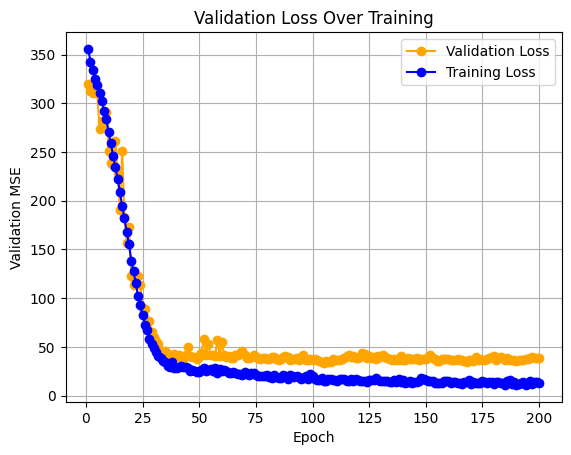

In [419]:
plt.figure()
plt.plot(range(1, len(val_losses) + 1), val_losses, marker="o", label="Validation Loss", color="orange")
plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o", label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("Validation Loss Over Training")
plt.grid(True)
plt.legend()
plt.show()

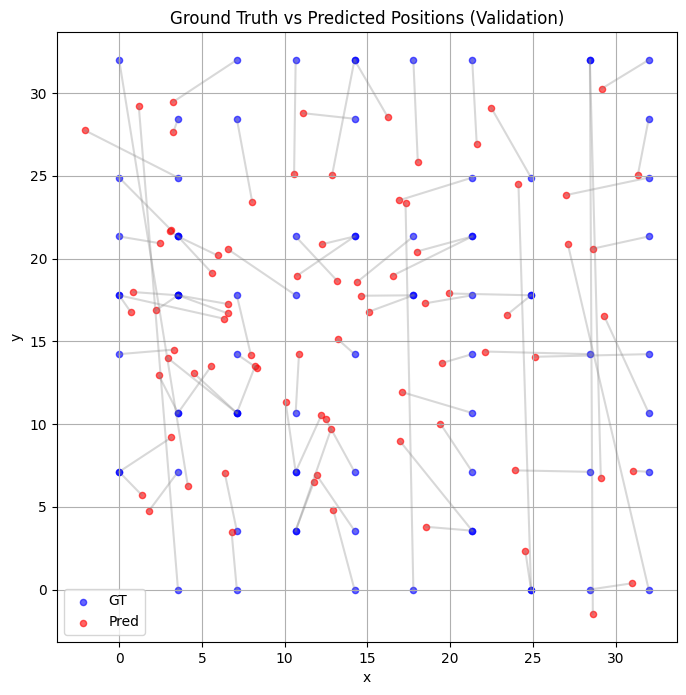

In [422]:
model.eval()
preds, gts = [], []
with torch.no_grad():
    for pos, hist in val_loader:
        pos, hist = pos.to(device), hist.to(device)
        pred = model(hist).cpu()
        # clip to 0 and 32
        # pred = torch.clamp(pred, min=0, max=32)
        preds.append(pred)
        gts.append(pos.cpu())
preds = torch.cat(preds)
gts   = torch.cat(gts)

plt.figure(figsize=(8, 8))
plt.scatter(gts[:, 0], gts[:, 1], c="blue",   label="GT",   s=20, alpha=0.6)
plt.scatter(preds[:, 0], preds[:, 1], c="red", label="Pred", s=20, alpha=0.6)
# Draw a line to show correspondence
for i in range(len(gts)):
    plt.plot([gts[i, 0], preds[i, 0]], [gts[i, 1], preds[i, 1]], c="gray", alpha=0.3)
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.title("Ground Truth vs Predicted Positions (Validation)")
plt.gca().set_aspect("equal", "box")
plt.grid(True)
plt.show()


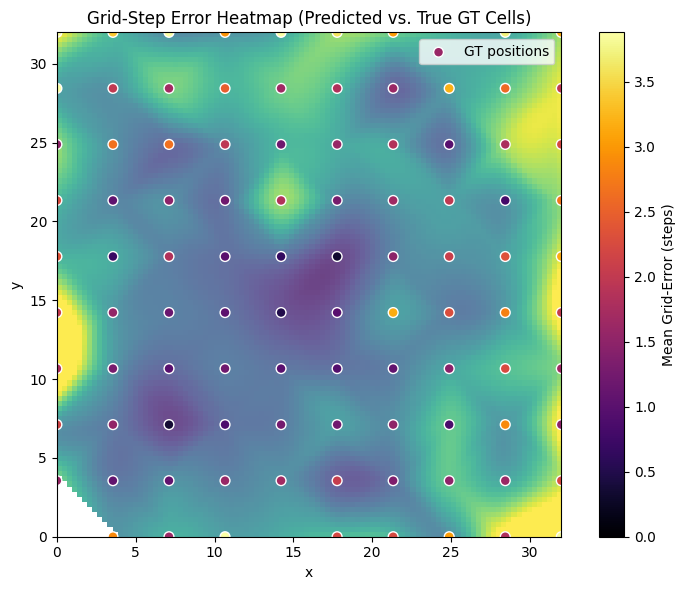

In [269]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

model.eval()
preds, gts = [], []
with torch.no_grad():
    for pos, hist in val_loader:
        pos, hist = pos.to(device), hist.to(device)
        preds.append(model(hist).cpu())
        gts.append(pos.cpu())
preds = torch.cat(preds)
gts   = torch.cat(gts)

# Convert to numpy
gt_np   = gts.numpy()
pred_np = preds.numpy()

# Group by unique GT positions
unique_gts, inverse = np.unique(gt_np, axis=0, return_inverse=True)

# Determine grid spacing (assuming a regular grid)
ux = np.unique(unique_gts[:, 0])
uy = np.unique(unique_gts[:, 1])
dx = np.min(np.diff(np.sort(ux)))
dy = np.min(np.diff(np.sort(uy)))

# Compute grid‐step error for each sample
grid_dx = np.round((pred_np[:, 0] - gt_np[:, 0]) / dx).astype(int)
grid_dy = np.round((pred_np[:, 1] - gt_np[:, 1]) / dy).astype(int)
grid_error = np.sqrt(grid_dx**2 + grid_dy**2)

# Mean grid‐error at each unique GT
mean_grid_error = np.array([
    grid_error[inverse == i].mean()
    for i in range(len(unique_gts))
])

# Create a regular grid over GT coordinate range
grid_x = np.linspace(unique_gts[:, 0].min(), unique_gts[:, 0].max(), 100)
grid_y = np.linspace(unique_gts[:, 1].min(), unique_gts[:, 1].max(), 100)
gx, gy = np.meshgrid(grid_x, grid_y)

# Interpolate mean_grid_error onto the 2D grid
gi = griddata(
    unique_gts,
    mean_grid_error,
    (gx, gy),
    method='cubic',
    fill_value=np.nan
)

# Clip extreme values (optional)
vmin, vmax = 0, np.nanpercentile(mean_grid_error, 95)

# Plot heatmap of mean grid‐error
plt.figure(figsize=(8, 6))
extent = [
    unique_gts[:, 0].min(),
    unique_gts[:, 0].max(),
    unique_gts[:, 1].min(),
    unique_gts[:, 1].max()
]
plt.imshow(
    gi.T,
    extent=extent,
    origin='lower',
    cmap='viridis',
    alpha=0.8,
    aspect='equal',
    vmin=vmin,
    vmax=vmax
)

# Overlay GT positions, colored by their clipped mean grid‐error
clipped_mge = np.clip(mean_grid_error, vmin, vmax)
plt.scatter(
    unique_gts[:, 0],
    unique_gts[:, 1],
    c=clipped_mge,
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    edgecolor='white',
    s=50,
    label='GT positions'
)

plt.colorbar(label='Mean Grid‐Error (steps)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Grid‐Step Error Heatmap (Predicted vs. True GT Cells)")
plt.legend()
plt.tight_layout()
plt.show()


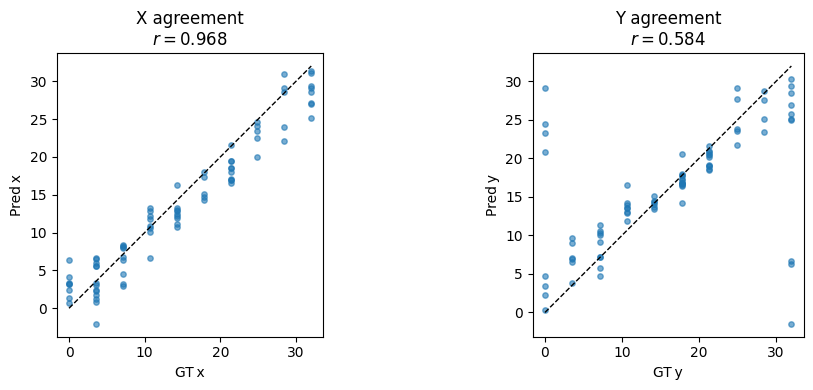

In [423]:
model.eval()
preds, gts = [], []
with torch.no_grad():
    for pos, hist in val_loader:
        pos, hist = pos.to(device), hist.to(device)
        preds.append(model(hist).cpu())
        gts.append(pos.cpu())
preds = torch.cat(preds)
gts   = torch.cat(gts)

from scipy.stats import pearsonr

r_x, _ = pearsonr(gts[:, 0], preds[:, 0])
r_y, _ = pearsonr(gts[:, 1], preds[:, 1])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(gts[:, 0], preds[:, 0], s=15, alpha=0.6)
axs[0].plot([gts[:, 0].min(), gts[:, 0].max()],
            [gts[:, 0].min(), gts[:, 0].max()], "k--", lw=1)
axs[0].set_xlabel("GT x")
axs[0].set_ylabel("Pred x")
axs[0].set_title(f"X agreement\n$r = {r_x:.3f}$")
axs[0].set_aspect("equal", "box")

axs[1].scatter(gts[:, 1], preds[:, 1], s=15, alpha=0.6)
axs[1].plot([gts[:, 1].min(), gts[:, 1].max()],
            [gts[:, 1].min(), gts[:, 1].max()], "k--", lw=1)
axs[1].set_xlabel("GT y")
axs[1].set_ylabel("Pred y")
axs[1].set_title(f"Y agreement\n$r = {r_y:.3f}$")
axs[1].set_aspect("equal", "box")

plt.tight_layout()
plt.show()
